# Credit Card Fraud Prediction Models
### *By Alexa Li*

## Project Overview

- ***Explore Data***: Perform exploratory analysis, plot variable distributions and scale the feature if necessary

- ***Model Development***: Split data into train and test; build and tune logistic regression and decision tree using both original and oversampled training dataset
    - *Improve Logistic Regression*: Tune parameter C to specify the regularization and choose the best model based on recall
    - *Improve Decision Tree*: Tune parameters criterion, max_depth, max_features and min_samples_split to minimize misclassification, maximize information gain while avoid over-fitting and/or under-fitting. Choose the best model based on recall.
- ***Model Comparison***: The key metrics for evaluating the model is **Recall** and **ROC**, because it does not hurt if we find a case is bad when it is actually not. However, it will hurt vice versa. So it is neccesary to capture as many bad cases as we can find by leveraging the model. I use ROC to tell how much the model is capable of distinguishing between classes

## Conclusion
Logistic Regression Base and Logistic Regression SMOTE have the same recall (93%), which means 93% of the actual bad cases were correctly classified. Logistic Regression SMOTE has a better ROC (98% vs 97%), which means it works better accuracy as a classifier. Therefore our champion model is **Logistic Regression SMOTE**. 

## Explore Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline

In [2]:
#Import data#
#Check column names#

raw_data = pd.read_csv("perf.csv")
raw_data.head()

,V1,V2,V3,V4,V5,V6,bad_flag
0,1.241518,0.317272,0.297462,0.634494,-0.864769,1.98,0
1,0.418615,1.512514,0.840490,-1.406947,0.346363,40.00,0
2,0.166944,-0.814257,-1.081547,0.416182,-0.869594,1.98,0
3,0.994426,-0.673374,0.304300,-0.763612,1.174625,118.91,0
4,0.295217,0.535843,1.514138,1.469108,1.157481,38.18,0


In [3]:
#Summary Stats#

raw_data.describe()

,V1,V2,V3,V4,V5,V6,bad_flag
count,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000
mean,-0.021832,0.382216,-0.680365,0.435030,-0.226965,90.617133,0.103427
std,0.931497,1.722909,3.417666,2.114453,1.396661,243.662115,0.304547
min,-4.498945,-3.962664,-31.103685,-5.024097,-9.498746,0.000000,0.000000
25%,-0.583852,-0.685727,-1.222773,-0.781717,-0.606320,4.580000,0.000000
50%,0.029583,0.110976,0.053042,0.147959,-0.029911,21.970000,0.000000
75%,0.624549,0.983338,0.974063,1.060273,0.469778,82.920000,0.000000
max,2.861654,12.018913,3.620346,12.114672,4.243841,8790.260000,1.000000


In [4]:
#Check missing values for each variable#

raw_data.isnull().sum()

V1          0
V2          0
V3          0
V4          0
V5          0
V6          0
bad_flag    0
dtype: int64

In [5]:
#Freq Table by Target Variable 'bad_flag'#

#Freq#
f = raw_data['bad_flag'].value_counts()

#Percentage#
p = raw_data['bad_flag'].value_counts(normalize = True).mul(100).round(2)

print(f)
print(p)

0    4265
1     492
Name: bad_flag, dtype: int64
0    89.66
1    10.34
Name: bad_flag, dtype: float64


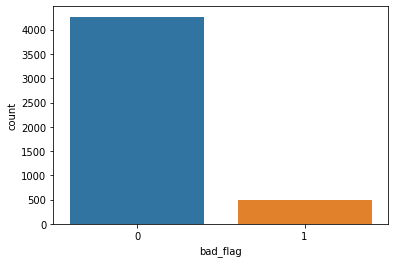

In [6]:
#Plot arget Variable

sns.countplot(raw_data['bad_flag'])

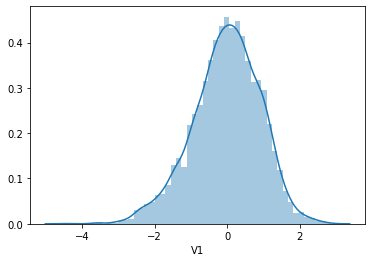

In [7]:
#Check variable distirbutions for V1
sns.distplot(raw_data['V1'])

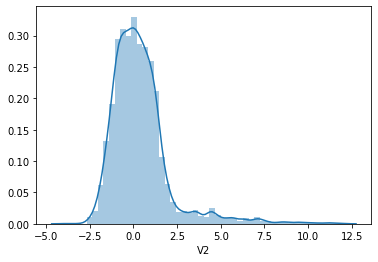

In [8]:
#Check variable distirbutions for V2
sns.distplot(raw_data['V2'])

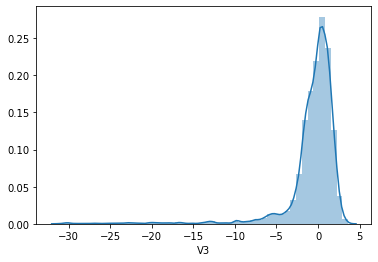

In [9]:
#Check variable distirbutions for V3
sns.distplot(raw_data['V3'])

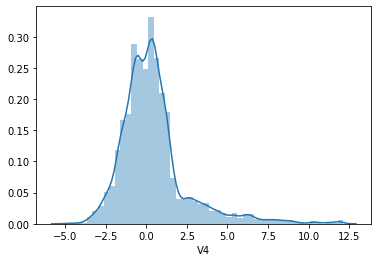

In [10]:
#Check variable distirbutions for V4
sns.distplot(raw_data['V4'])

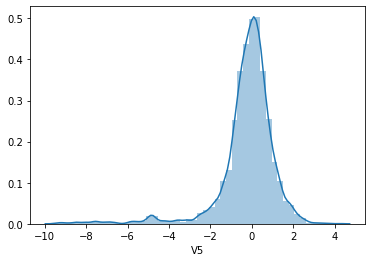

In [11]:
#Check variable distirbutions for V5
sns.distplot(raw_data['V5'])

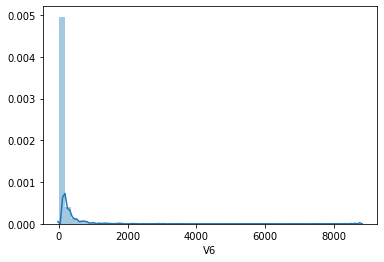

In [12]:
#Check variable distirbutions for V6
sns.distplot(raw_data['V6'])

**Based on the information above, we learned:**

- There is no missing value in the data so we do not have to impute missing value.
- V6 does not follow normal distribution. we need to make feature scaling for V6.
- Based on the barchart for target variable *bad_flag*, this is an imbalanced dataset. Only 10.34% of the cases are bad. The resampling method is necessary to make a good model.

## Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
#Transform V6 AS transV6#
#Drop V6#

raw_data['transV6'] = StandardScaler().fit_transform(raw_data['V6'].values.reshape(-1,1))
data = raw_data.drop(['V6'], axis = 1)
data.head()

,V1,V2,V3,V4,V5,bad_flag,transV6
0,1.241518,0.317272,0.297462,0.634494,-0.864769,0,-0.363809
1,0.418615,1.512514,0.840490,-1.406947,0.346363,0,-0.207757
2,0.166944,-0.814257,-1.081547,0.416182,-0.869594,0,-0.363809
3,0.994426,-0.673374,0.304300,-0.763612,1.174625,0,0.116127
4,0.295217,0.535843,1.514138,1.469108,1.157481,0,-0.215227


## Build Models

In this step, I will build decision tree and logistic regression using train and test data split. I will first split the dataset as training and build the base model, then try oversampling to compare with the base. My hypothesis is oversampling will give better performance because a larger dataset input would make the model more robust and stable. 

### Train test data split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x = data.drop('bad_flag', axis = 1)
y = data['bad_flag']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 1234)

### Logistic Regression (Base)

In [18]:
#Build Model and Tune Parameters#

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, make_scorer, precision_recall_curve

- **Improve Logistic Regression by Grid Search**

Grid search builds a model for every combination of hyperparameters specified and evaluates each model. Here I use Grid Search to maximize Recall. The parameter I tuned is C, which is inverse of regularization strength - smaller values of C specify stronger regularization.

In [19]:
#Build grid#

recall_score = make_scorer(recall_score)

logit_search = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid = {'C':[0.1, 0.3, 1, 3, 10, 30, 100]}, scoring = recall_score)

In [20]:
#Find the best model based on Recall#

logit_search.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.3, 1, 3, 10, 30, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(recall_score), verbose=0)

In [21]:
logit_search.best_params_

{'C': 0.3}

In [22]:
logit_predictions = logit_search.predict(x_test)

In [23]:
logit_prob = logit_search.predict_proba(X = x_test)[:,1]

In [24]:
print(classification_report(y_test, logit_predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1280
           1       0.96      0.82      0.88       148

    accuracy                           0.98      1428
   macro avg       0.97      0.91      0.94      1428
weighted avg       0.98      0.98      0.98      1428



### Decision Tree (Base)

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

- **Improve Decision Tree by Tuning the following parameters**:
    - ***criterion***: using gini and entropy to measure the quality of the split, gini gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. A perfect separation results in a Gini score of 0. Entropy decides the information gain, it is a measure of disorder or uncertainty. High entropy means high level of disorder 
    - ***max_depth***: the depth parameter is one of the ways in which we can regularize the tree, or limit the way it grows to prevent over-fitting
    - ***max_feature***: avoid under-fitting and/or overfitting
    - ***min_samples_split***: when increasing this parameter, the tree becomes more constrained as it has to consider more samples at each node

In [26]:
dtree = DecisionTreeClassifier()

dtree_param = {"criterion": ["gini", "entropy"],
               "max_depth": [3, None],
              "max_features": sp.stats.randint(1, 6),
              "min_samples_split": sp.stats.randint(2, 14),
              }

dtree_search = RandomizedSearchCV(dtree, param_distributions = dtree_param,  scoring = recall_score)

In [27]:
dtree_search.fit(x_train,y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
       

In [28]:
dtree_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 5,
 'min_samples_split': 13}

In [29]:
dtree_predictions = dtree_search.predict(x_test)

In [30]:
dtree_prob = dtree_search.predict_proba(x_test)[:,1]

In [31]:
print(classification_report(y_test, dtree_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1280
           1       0.84      0.84      0.84       148

    accuracy                           0.97      1428
   macro avg       0.91      0.91      0.91      1428
weighted avg       0.97      0.97      0.97      1428



### ROC Curve & Precision - Recall Curve
*Plot ROC Curve & Precision - Recall Curve for the models we have built so far.*

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

In [33]:
models = [
    {'label':'Logistic Regression',
     'fpr': roc_curve(y_test,logit_prob)[0],
     'tpr': roc_curve(y_test,logit_prob)[1],
     'auc': auc(roc_curve(y_test,logit_prob)[0], roc_curve(y_test,logit_prob)[1]),
     'precision': precision_recall_curve(y_test,logit_prob)[0],
     'recall': precision_recall_curve(y_test,logit_prob)[1],
     'pr-auc': auc(precision_recall_curve(y_test,logit_prob)[1], precision_recall_curve(y_test,logit_prob)[0])
    },
    {
     'label':'Decision Tree',
     'fpr': roc_curve(y_test,dtree_prob)[0],
     'tpr': roc_curve(y_test,dtree_prob)[1],
     'auc': auc(roc_curve(y_test,dtree_prob)[0], roc_curve(y_test,dtree_prob)[1]),
     'precision': precision_recall_curve(y_test,dtree_prob)[0],
     'recall': precision_recall_curve(y_test,dtree_prob)[1],
     'pr-auc': auc(precision_recall_curve(y_test,dtree_prob)[1], precision_recall_curve(y_test,dtree_prob)[0])
    }
]

<Figure size 432x288 with 0 Axes>

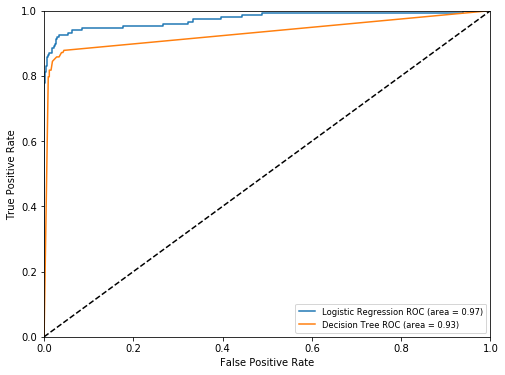

In [34]:
plt.clf()
plt.figure(figsize = (8,6))

for m in models:
    plt.plot(m['fpr'], m['tpr'], label = '%s ROC (area = %0.2f)' % (m['label'], m['auc']))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')

<Figure size 432x288 with 0 Axes>

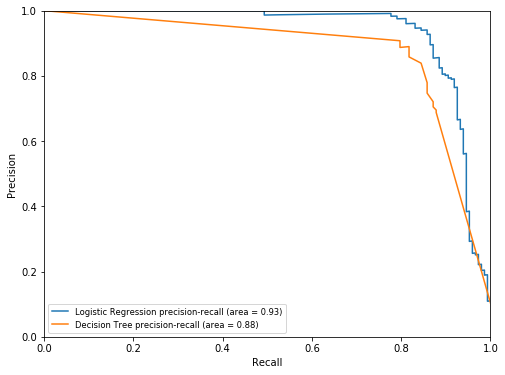

In [35]:
plt.clf()
plt.figure(figsize = (8,6))

for m in models:
    plt.plot(m['recall'], m['precision'], label = '%s precision-recall (area = %0.2f)' % (m['label'], m['pr-auc']))
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 0, fontsize = 'small')

### Oversampling by SMOTE

Now I will try oversampling (duplicate minority examples) and build models to compare performance. The issue with this approach is that the decision boundary will be more specific and hence might cause over-fitting.

Therefore, I will use a very popular sampling method named SMOTE (Synthetic Minority Over-Sampling Technique). The advantage of SMOTE is that it is creating synthetic examples of minority class so the decision boundary is more general.

In [46]:
from imblearn.over_sampling import SMOTE

In [37]:
#Oversample the minority class by 400% to reach to a more balanced dataset#

train_data = x_train.copy()
train_data['bad_flag'] = y_train
bad_data = train_data[train_data['bad_flag'] == 1]
bad_size = len(bad_data)

In [38]:
minor_size = bad_size * 4
non_bad_data = train_data[train_data['bad_flag'] == 0].sample(n = minor_size, random_state = 101)
SMOTE_data = pd.concat([bad_data, non_bad_data])
SMOTE_x = SMOTE_data.drop('bad_flag', axis = 1)
SMOTE_y = SMOTE_data['bad_flag']

## Build Models (Oversampling)
*Build logistic regression and decision tree using oversampled data*

### Train & Test Data Split

In [39]:
SMOTE_x_train = SMOTE_x
SMOTE_x_test = x_test
SMOTE_y_train = SMOTE_y
SMOTE_y_test = y_test

### Logistic Regression

In [40]:
SMOTE_logit = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid = {'C':[0.1, 0.3, 1, 3, 10, 30, 100]}, scoring = recall_score)
SMOTE_logit.fit(SMOTE_x_train,SMOTE_y_train)
SMOTE_logit_predictions = SMOTE_logit.predict(SMOTE_x_test)
SMOTE_logit_prob = SMOTE_logit.predict_proba(SMOTE_x_test)[:,1]

print(classification_report(SMOTE_y_test, SMOTE_logit_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1280
           1       0.91      0.86      0.89       148

    accuracy                           0.98      1428
   macro avg       0.95      0.92      0.94      1428
weighted avg       0.98      0.98      0.98      1428



### Decision Tree

In [41]:
SMOTE_dtree = RandomizedSearchCV(dtree, param_distributions = dtree_param, scoring = recall_score)
SMOTE_dtree.fit(SMOTE_x_train, SMOTE_y_train)
SMOTE_dtree_predictions = SMOTE_dtree.predict(SMOTE_x_test)
SMOTE_dtree_prob = SMOTE_dtree.predict_proba(SMOTE_x_test)[:,1]

print(classification_report(SMOTE_y_test, SMOTE_dtree_predictions))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1280
           1       0.76      0.83      0.80       148

    accuracy                           0.96      1428
   macro avg       0.87      0.90      0.89      1428
weighted avg       0.96      0.96      0.96      1428



In [42]:
SMOTE_models = [
    {'label':'Logistic Regression - SMOTE',
     'fpr': roc_curve(SMOTE_y_test,SMOTE_logit_prob)[0],
     'tpr': roc_curve(SMOTE_y_test,SMOTE_logit_prob)[1],
     'auc': auc(roc_curve(SMOTE_y_test,SMOTE_logit_prob)[0], roc_curve(SMOTE_y_test,SMOTE_logit_prob)[1]),
     'precision': precision_recall_curve(SMOTE_y_test,SMOTE_logit_prob)[0],
     'recall': precision_recall_curve(SMOTE_y_test,SMOTE_logit_prob)[1],
     'pr-auc': auc(precision_recall_curve(SMOTE_y_test,SMOTE_logit_prob)[1], precision_recall_curve(SMOTE_y_test,SMOTE_logit_prob)[0])
    },
    {
     'label':'Decision Tree - SMOTE',
     'fpr': roc_curve(SMOTE_y_test,SMOTE_dtree_prob)[0],
     'tpr': roc_curve(SMOTE_y_test,SMOTE_dtree_prob)[1],
     'auc': auc(roc_curve(SMOTE_y_test,SMOTE_dtree_prob)[0], roc_curve(SMOTE_y_test,SMOTE_dtree_prob)[1]),
     'precision': precision_recall_curve(SMOTE_y_test,SMOTE_dtree_prob)[0],
     'recall': precision_recall_curve(SMOTE_y_test,SMOTE_dtree_prob)[1],
     'pr-auc': auc(precision_recall_curve(SMOTE_y_test,SMOTE_dtree_prob)[1], precision_recall_curve(SMOTE_y_test,SMOTE_dtree_prob)[0])  
    }
]

## Combine Base and Oversampled Models for Comparison

In [43]:
all_models = models + SMOTE_models

### Plot ROC Curves & Precision - Recall Curves

<Figure size 432x288 with 0 Axes>

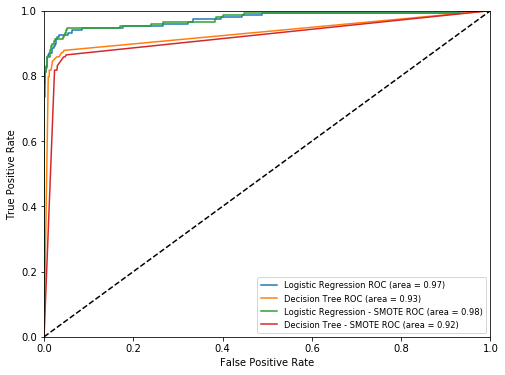

In [44]:
plt.clf()
plt.figure(figsize = (8,6))

for m in all_models:
    plt.plot(m['fpr'], m['tpr'], label = '%s ROC (area = %0.2f)' % (m['label'], m['auc']))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')

<Figure size 432x288 with 0 Axes>

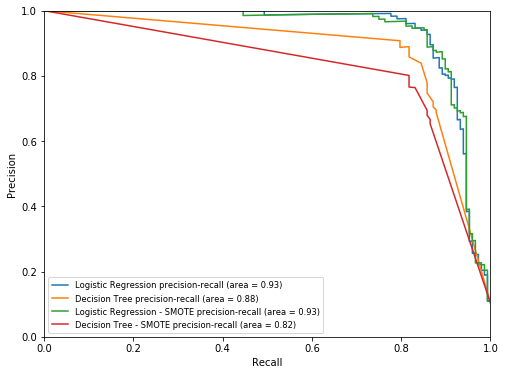

In [45]:
plt.clf()
plt.figure(figsize = (8,6))

for m in all_models:
    plt.plot(m['recall'], m['precision'], label = '%s precision-recall (area = %0.2f)' % (m['label'], m['pr-auc']))
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=0, fontsize='small')

## Conclusion
Logistic Regression SMOTE is the champion model based on ROC and Recall.